In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris/Iris.csv
/kaggle/input/iris/database.sqlite


In [42]:
iris_data = pd.read_csv('../input/iris/Iris.csv')
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


##### 분류가 아니라 군집화를 할 거라 Species는 필요가 없음.

##### I'm going to cluster, not classification. So I don't need Species.

In [44]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(iris_data["Species"])
iris_data["Species"] = le.transform(iris_data["Species"])

iris_label = iris_data["Species"] # save labels for visualize

del iris_data["Id"]
del iris_data["Species"]

iris_data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [63]:
def visualize_plots(iris_data, ax1_name, ax2_name, kmeans = None, is_ax1_kmeans = False, is_ax2_kmeans = False) :
    
    fig, (ax1, ax2) = plt.subplots(figsize = (9, 5), ncols = 2)

    for i, marker in enumerate(['s', 'o', '^']) :
        x_axis_data = iris_data[iris_data['cluster'] == i]['SepalLengthCm']
        y_axis_data = iris_data[iris_data['cluster'] == i]['SepalWidthCm']
        ax1.scatter(x_axis_data, y_axis_data, marker=marker)

        x_axis_data = iris_data[iris_data['target'] == i]['SepalLengthCm']
        y_axis_data = iris_data[iris_data['target'] == i]['SepalWidthCm']
        ax2.scatter(x_axis_data, y_axis_data, marker=marker)
    
    if is_ax1_kmeans : ax1.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="*") #visualize center points of clusters
    elif is_ax2_kmeans : ax2.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="*") #visualize center points of clusters
        
    ax1.set_title(ax1_name)
    ax2.set_title(ax2_name)
    
    plt.show()

# K-Means

##### 실루엣 계수를 통해 몇 개의 데이터 셋으로 군집화해야 좋은지 파악 가능.

##### Determine how many datasets I need to cluster together by using Silhouette Score.


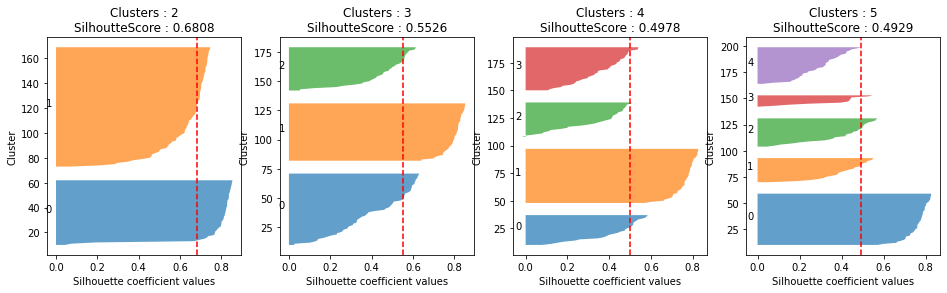

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt


cluster_nums = [2, 3, 4, 5]
nums_cnt = len(cluster_nums)

fig, ax = plt.subplots(figsize = (16, 4), nrows = 1, ncols = nums_cnt)
for i, cluster_num in enumerate(cluster_nums) :
    cluster = KMeans(n_clusters = cluster_num, max_iter = 100, random_state = 0)
    predict = cluster.fit_predict(iris_data)
    
    sil_avg = silhouette_score(iris_data, predict)
    sil_val = silhouette_samples(iris_data, predict)
    
    y_lower = 10
    ax[i].set_title('Clusters : {0}\nSilhoutteScore : {1:.4f}'.format(cluster_num, sil_avg))
    ax[i].set_xlabel('Silhouette coefficient values')
    ax[i].set_ylabel('Cluster')
    
    for j in range(cluster_num) :
        cluster_val = sil_val[predict == j]
        cluster_val.sort()
        y_upper = y_lower + cluster_val.shape[0]
        
        ax[i].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_val, alpha = 0.7)
        ax[i].text(-0.05, y_lower + 0.5 * cluster_val.shape[0], str(j))
        y_lower = y_upper + 10
    
    ax[i].axvline(x = sil_avg, color = "red", linestyle = "--")

##### 3이 제일 좋아보임.
##### 3 looks best

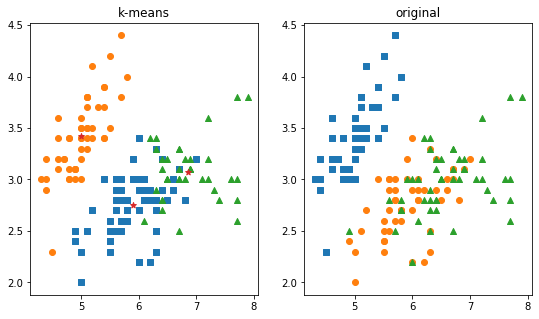

In [65]:
from sklearn.cluster import KMeans

iris_kmeans = iris_data.copy()

kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 100, random_state = 0)
kmeans.fit(iris_kmeans)

iris_kmeans["target"] = iris_label
iris_kmeans["cluster"] = kmeans.labels_

visualize_plots(iris_kmeans, ax1_name = 'k-means', ax2_name = 'original', kmeans = kmeans, is_ax1_kmeans = True)

# PCA (주성분분석, Principal component analysis)

Text(0.5, 1.0, 'K-Means')

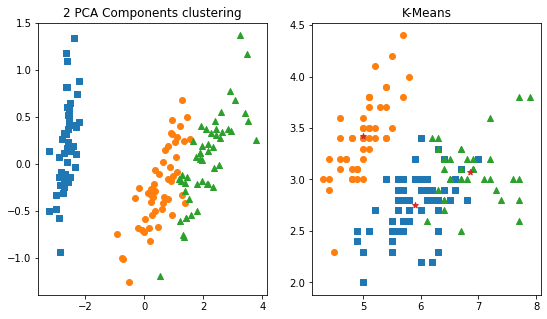

In [67]:
from sklearn.decomposition import PCA

iris_pca = iris_data.copy()

pca = PCA(n_components=2) # For visualize in 2D shape
pca_predict = pca.fit_transform(iris_pca)

iris_pca = pd.DataFrame(pca_predict, columns=['pca_x', 'pca_y'])
iris_pca['target'] = iris_label

fig, (ax1, ax2) = plt.subplots(figsize = (9, 5), ncols = 2)

for i, marker in enumerate(['s', 'o', '^']) :
    mark = iris_pca[iris_pca['target'] == i].index
    ax1.scatter(x = iris_pca.loc[mark, 'pca_x'], y = iris_pca.loc[mark, 'pca_y'], marker = marker)

    x_axis_data = iris_kmeans[iris_kmeans['cluster'] == i]['SepalLengthCm']
    y_axis_data = iris_kmeans[iris_kmeans['cluster'] == i]['SepalWidthCm']
    ax2.scatter(x_axis_data, y_axis_data, marker=marker)
    
ax2.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="*") #visualize center points of clusters
ax1.set_title('2 PCA Components clustering')
ax2.set_title('K-Means')

# Mean Shift

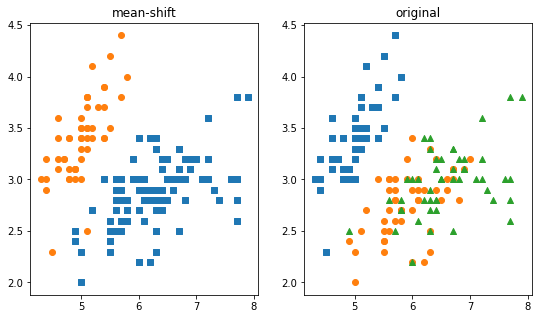

In [68]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy import stats

iris_ms = iris_data.copy()

#최적의 대역폭 계산 : estimate the best bandwidth
bandwidth = estimate_bandwidth(iris_ms)
meanshift = MeanShift(bandwidth = bandwidth)
labels = meanshift.fit_predict(iris_ms)

iris_ms['target'] = iris_label
iris_ms['cluster'] =  labels

visualize_plots(iris_ms, ax1_name = 'mean-shift', ax2_name = 'original')

# GMM (가우시안 혼합 모델, Gaussian Mixture Model)

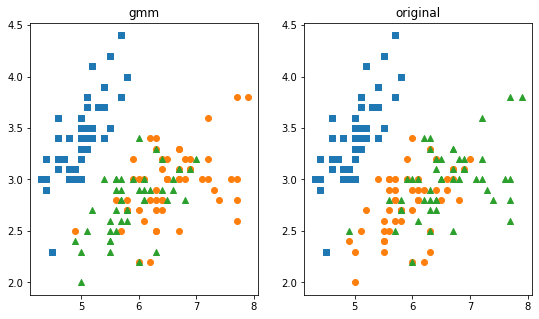

In [69]:
from sklearn.mixture import GaussianMixture

iris_gmm = iris_data.copy()

gmm = GaussianMixture(n_components=3, random_state = 0).fit(iris_gmm)
gmm_cluster = gmm.predict(iris_gmm)

iris_gmm['cluster'] = gmm_cluster
iris_gmm['target'] = iris_label


visualize_plots(iris_gmm, ax1_name = 'gmm', ax2_name = 'original')

# DBSCAN (밀도 기반 군집화, Density Based Spatial Clustering of Applications with Noise)

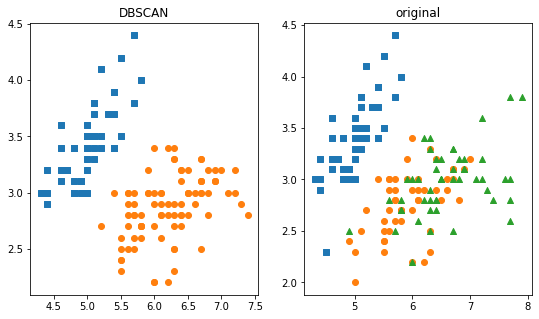

In [79]:
from sklearn.cluster import DBSCAN

iris_dbs = iris_data.copy()

dbscan = DBSCAN(eps=0.6, min_samples = 8, metric='euclidean')
dbscan_cluster = dbscan.fit_predict(iris_data)

iris_dbs['cluster'] = dbscan_cluster
iris_dbs['target'] = iris_label


visualize_plots(iris_dbs, ax1_name = 'DBSCAN', ax2_name = 'original')

##### DBSCAN은 군집 수를 자동으로 정하기에, 노이즈를 많이 만들 수 있음.
##### DBSCAN automatically determines the number of clusters, which can make a lot of noise.
##### 
##### PCA를 함께 사용하면 노이즈 시각화 가능.
##### PCA can be used together to visualize noise.

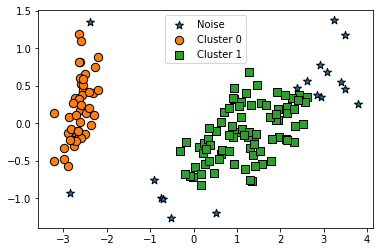

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


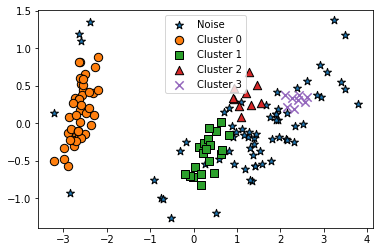

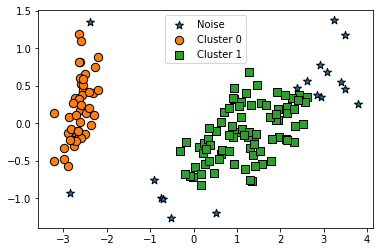

In [78]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['pca1'], y=label_cluster['pca2'], s=70, edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise: legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()
    

pca = PCA(n_components=2, random_state = 0)
pca_transformed = pca.fit_transform(iris_data)

iris_dbs['pca1'] = pca_transformed[:,0]
iris_dbs['pca2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, iris_dbs, 'cluster',iscenter=False)


# eps가 줄어들거나, min_samples가 늘어나면 노이즈 증가
# Reducing eps or increasing min_samples increases noise
dbscan = DBSCAN(eps=0.4, min_samples = 8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris_data)

iris_dbs = iris_data.copy()
iris_dbs['cluster'] = dbscan_labels
iris_dbs['target'] = iris_label

iris_dbs['pca1'] = pca_transformed[:,0]
iris_dbs['pca2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, iris_dbs, 'cluster',iscenter=False)


# eps가 늘어나거나, min_samples가 줄어들면 노이즈 감소
# Increasing eps or reducing min_samples decreases noise
dbscan = DBSCAN(eps=0.6, min_samples = 12, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris_data)

iris_dbs = iris_data.copy()
iris_dbs['cluster'] = dbscan_labels
iris_dbs['target'] = iris_label

iris_dbs['pca1'] = pca_transformed[:,0]
iris_dbs['pca2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, iris_dbs, 'cluster',iscenter=False)